# Avito Demand Prediction Challenge

## This is our final aggregated and cleaned notebook. Some of the cells didn't run in this notebook, but our final resuts were generated from the pervious versions of this notebook. 

##### Group Member Yue Cheng, Elvis Leng, Xin Su, Weihao Zeng

In [1]:
import pandas as pd
import numpy as np
import string
from string import digits
from sklearn.model_selection import train_test_split
import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator 
from h2o.estimators.random_forest import H2ORandomForestEstimator
from h2o.grid.grid_search import H2OGridSearch 
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.stackedensemble import H2OStackedEnsembleEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator
from h2o.grid.grid_search import H2OGridSearch 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer


### We are going to read in the data, and for the activation_date we are going to read in as date type.

In [2]:
train_raw = pd.read_csv("train.csv", parse_dates=["activation_date"])
test = pd.read_csv("test.csv", parse_dates=["activation_date"])


### Below we splited our data into train, validation, train stack, and validation stack. We need different pairs of trainning and validation set to train our base models and stack model. 

In [5]:
base, stack= train_test_split( train_raw, test_size=0.5,random_state=123)
train_df,valid_df=train_test_split( base, test_size=0.2,random_state=123)
train_stack,valid_stack=train_test_split( stack, test_size=0.2,random_state=123)

## Data cleaning: 
### 1. We are going to clean the data to first fill the NA values with empty space. We don't fill with 'None' because we are going count the words and the length.
### 2. For the column price, we decided to fill the NA values with random choices from the existing values and add some noise to it. 

In [ ]:
train_df.isnull().sum()

In [6]:
for data in [train_df,valid_df,train_stack,valid_stack,test]:
    data['description'] = data['description'].fillna(' ')
    data['title'] = data['title'].fillna(' ')
    data['price']=data['price'].fillna(np.random.choice(data['price'].dropna()+np.random.normal(0,50)))
    for column in ['param_1','param_2','param_3','image','image_top_1']:
        data[column]=data[column].fillna(' ')


/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

In [ ]:
train_df.isnull().sum()

## feature engineering
### 1. We are going to add the day, month, and week column to the data set. We think selling stuff at different days of the week and different weeks of the month will affect the chance of selling. 
### 2. We also added the lenth of the description as new columns.
### 3. We also changed the weekday variable to english, so it is be a categorical variable now.


In [7]:
for data in [train_df,valid_df,train_stack,valid_stack,test]:

    data['weekday'] = data.activation_date.dt.weekday
    data['month'] = data.activation_date.dt.month
    data['day'] = data.activation_date.dt.day
    data['week'] = data.activation_date.dt.week 

# length of description
    data['description_len'] = data['description'].apply(lambda x : len(x.split()))

# length of title
    data['title_len'] = data['title'].apply(lambda x : len(x.split()))

# param_combined and its length
    data['param_combined'] = data.apply(lambda row: ' '.join([str(row['param_1']), str(row['param_2']),  str(row['param_3'])]), axis=1)
    data['param_combined'] = data['param_combined'].fillna("none")
    data['param_combined_len'] = data['param_combined'].apply(lambda x : len(x.split()))

# charater len of text columns
    data['description_char'] = data['description'].apply(len)
    data['title_char'] = data['title'].apply(len)
    data['param_char'] = data['param_combined'].apply(len)

# english mapped of weekday
    daymap = {0:'Sun', 1:'Mon', 2:'Tue', 3:'Wed', 4:'Thu', 5:'Fri', 6:'Sat'}
    data['weekday_en'] = data['weekday'].apply(lambda x : daymap[x])





/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

In [8]:
train_df.dtypes

item_id                         object
user_id                         object
region                          object
city                            object
parent_category_name            object
category_name                   object
param_1                         object
param_2                         object
param_3                         object
title                           object
description                     object
price                          float64
item_seq_number                  int64
activation_date         datetime64[ns]
user_type                       object
image                           object
image_top_1                     object
deal_probability               float64
weekday                          int64
month                            int64
day                              int64
week                             int64
description_len                  int64
title_len                        int64
param_combined                  object
param_combined_len       

In [9]:
train_df.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,day,week,description_len,title_len,param_combined,param_combined_len,description_char,title_char,param_char,weekday_en
483951,270c38770ced,40322123588f,Удмуртия,Воткинск,Животные,Другие животные,С/х животные,,,Продам Вьетнамского хряка производителя,...,26,12,10,4,С/х животные,2,93,39,16,Sat
1368194,284cce5ff1bf,e137387ba975,Краснодарский край,Краснодар,Хобби и отдых,Спорт и отдых,Другое,,,Лонда,...,17,11,4,1,Другое,1,28,5,10,Thu
145682,734303f67075,3d001ae3dcdf,Ростовская область,Ростов-на-Дону,Недвижимость,"Дома, дачи, коттеджи",Продам,Дом,,Дом 67 м² на участке 1.7 сот.,...,16,11,14,7,Продам Дом,2,99,29,12,Wed
1311019,fa42898b5df7,034a1464686b,Воронежская область,Воронеж,Для дома и дачи,Ремонт и строительство,Стройматериалы,,,Трубы профильные для заборов и металлоконструкций,...,21,12,4,6,Стройматериалы,1,178,49,18,Mon
882399,f201d565c36f,c04f9562479f,Ростовская область,Ростов-на-Дону,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Платья и юбки,42–44 (S),Новое джинсовое платье,...,16,11,15,3,Женская одежда Платья и юбки 42–44 (S),7,93,22,38,Wed


### After checking each column and its data type, we decided to correct the miss matched columns. 

In [10]:
for data in [train_df,valid_df,train_stack,valid_stack,test]:
    for column in ["item_seq_number","image_top_1","weekday","week","day","month"]:
        data[column]=data[column].astype('str')

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [11]:
train_df.shape

(601369, 30)

In [12]:
train_stack.shape

(601369, 30)

## text engineering

### We believe that the Ad description will affct the deal probability greatly, so we are going to do text engineering to make the description as part of our dataset that can be used for our final prediction.

### We are going to add columns by each word and count the occurence of the word for each row. Since we are going to find the effect of those popular and meaningful word, we believe these words would show multiple times, then it would be convinient and fast to find these words using 10% sample.

In [13]:
random=train_df[["title","description"]].sample(frac=0.1, replace=False,random_state=123)

In [14]:
random.shape

(60137, 2)

### We are creating a list, and add all the lowered words without punctuations and digits to the list.

In [15]:
content= []

#replace punctuation with space
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))

#remove digits
remove_digits = str.maketrans('', '', digits)


#split the words and add each word to the list
for words in random["description"]:
    word=words.translate(remove_digits).translate(translator).lower().split()
    content+=word
    
for words in random["title"]:
    word=words.translate(remove_digits).translate(translator).lower().split()
    content+=word

# check how many unique content we have
u_content = list(set(content))

len(u_content)

105633

### There are a lot more words than what we can use for our final model, so below we are going to select some of them according to frequency that the word appears. 

In [16]:
from collections import Counter
counts=Counter(content)
print(counts)

Counter({'в': 50186, 'и': 35437, 'на': 33435, 'с': 21716, 'для': 18299, 'по': 14378, 'не': 12623, 'продам': 12368, 'состоянии': 11093, 'размер': 7860, 'р': 7847, 'от': 7639, 'см': 7459, 'все': 7266, 'к': 7116, 'состояние': 6763, 'до': 6093, 'за': 6044, 'есть': 5940, 'из': 5530, 'квартира': 5392, 'у': 5302, 'м': 5233, 'очень': 5135, 'м²': 5027, 'хорошем': 4864, 'руб': 4619, 'без': 4373, 'отличном': 4359, 'торг': 4164, 'цена': 4146, 'продаю': 4132, 'новые': 4122, 'платье': 3786, 'новый': 3780, '—': 3685, 'или': 3610, 'х': 3573, 'эт': 3492, 'можно': 3416, 'б': 3407, 'дом': 3275, 'как': 2929, 'новая': 2896, 'мм': 2849, 'под': 2847, 'а': 2784, 'при': 2780, 'г': 2747, 'куртка': 2659, 'так': 2605, 'цвет': 2576, 'фото': 2424, 'отличное': 2357, 'лет': 2274, 'звоните': 2227, 'года': 2200, 'раз': 2160, 'кв': 2156, 'продается': 2049, 'хорошее': 2035, 'шт': 1995, 's': 1965, '•': 1953, '–': 1936, 'кг': 1927, 'работы': 1908, 'комплект': 1890, 'но': 1883, 'что': 1869, 'доставка': 1852, 'участок': 1833

In [17]:
# create a word dictionary, and store the key and values

words = list((v) for k, v in counts.items())
word=pd.DataFrame({'word':words})
word.describe()

,word
count,105633.000000
mean,15.105838
std,271.019437
min,1.000000
25%,1.000000
50%,2.000000
75%,4.000000
max,50186.000000


### Because there are too many words, we are only going to choose some of them, which could be useful to predit deal probability, as our new variables. From the pervious output we can see that the frenquency of the words are extremely skewed, so we are going to choose the ones that are popular, but not the most popular, because we believe the ones that have the highest counts are most likely to be generic verbs. Hence, we chose the quantile of 0.989 to 0.991. We do not want to have too many column, so we chose a small fraction of the popular words to be used in our model. Then we check these selected words and find they are quite meaningful.

In [18]:
lowerbound=int(word.quantile(.989))
higherbound=int(word.quantile(.991))

In [19]:
keep_word = dict((k, v) for k, v in counts.items() if  v in range(lowerbound,higherbound)  )
keep_word

{'acer': 207,
 'amd': 205,
 'apple': 208,
 'canon': 194,
 'geforce': 184,
 'hdd': 190,
 'hdmi': 206,
 'in': 213,
 'lte': 185,
 'mb': 188,
 'mhz': 184,
 'mm': 195,
 'msi': 197,
 'nike': 178,
 'xx': 208,
 'аппарат': 212,
 'бампер': 188,
 'батарея': 188,
 'белая': 210,
 'белые': 206,
 'бизнес': 213,
 'блока': 194,
 'будем': 206,
 'будут': 187,
 'были': 193,
 'было': 191,
 'ванной': 191,
 'вашим': 208,
 'вещь': 212,
 'внешний': 189,
 'воду': 213,
 'встроенный': 214,
 'выписку': 191,
 'выход': 210,
 'газель': 187,
 'городе': 194,
 'дачу': 181,
 'девочек': 179,
 'дерево': 185,
 'детское': 184,
 'детской': 212,
 'дешевле': 178,
 'днп': 195,
 'добрые': 214,
 'домик': 196,
 'домом': 210,
 'доплатой': 205,
 'доставки': 203,
 'дюймов': 202,
 'женский': 188,
 'жизни': 209,
 'застройщика': 199,
 'зимой': 191,
 'игр': 210,
 'игровой': 203,
 'игрушка': 198,
 'ипотеку': 195,
 'каждая': 195,
 'капитал': 202,
 'карта': 190,
 'кафель': 180,
 'качественная': 210,
 'качественные': 190,
 'книга': 188,
 'кни

In [20]:
len(keep_word)

215

### After getting all the new words and their counts as its own dataframe, we are going to combine them with the orginal dataframe. In the combined dataframe, each row will have their orignals information and the count of popular words they have. 

In [21]:
to_count=set(keep_word)
to_count

{'acer',
 'amd',
 'apple',
 'canon',
 'geforce',
 'hdd',
 'hdmi',
 'in',
 'lte',
 'mb',
 'mhz',
 'mm',
 'msi',
 'nike',
 'xx',
 'аппарат',
 'бампер',
 'батарея',
 'белая',
 'белые',
 'бизнес',
 'блока',
 'будем',
 'будут',
 'были',
 'было',
 'ванной',
 'вашим',
 'вещь',
 'внешний',
 'воду',
 'встроенный',
 'выписку',
 'выход',
 'газель',
 'городе',
 'дачу',
 'девочек',
 'дерево',
 'детское',
 'детской',
 'дешевле',
 'днп',
 'добрые',
 'домик',
 'домом',
 'доплатой',
 'доставки',
 'дюймов',
 'женский',
 'жизни',
 'застройщика',
 'зимой',
 'игр',
 'игровой',
 'игрушка',
 'ипотеку',
 'каждая',
 'капитал',
 'карта',
 'кафель',
 'качественная',
 'качественные',
 'книга',
 'книги',
 'коврик',
 'колонки',
 'кольцо',
 'ком',
 'комнате',
 'комод',
 'комфорт',
 'костюмчик',
 'котофей',
 'красиво',
 'кресла',
 'кухне',
 'легкие',
 'легкий',
 'линолеум',
 'литров',
 'любом',
 'мастер',
 'материала',
 'меня',
 'металлическая',
 'механизм',
 'мини',
 'многое',
 'моделей',
 'москитная',
 'напряжение'

In [22]:
translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
remove_digits = str.maketrans('', '', digits)


for data in [train_df]:
    
    #create lists to store the word list
    titlelist=[]
    descriptionlist=[]

    
    #for each row, we translate the content into sperated words
    for i in range(0,len(data["title"])):
        titlelist.append(data.loc[data.index[i], 'title'].translate(remove_digits).translate(translator).lower())
    
    for i in range(0,len(data["description"])):
        descriptionlist.append(data.loc[data.index[i], 'description'].translate(remove_digits).translate(translator).lower())
    
    # for selected word in each row, count the frequency of that word and store the value in the corresponding word column
    vec = CountVectorizer(vocabulary=to_count)
    X = vec.fit_transform(titlelist)
    title = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())


    X = vec.fit_transform(descriptionlist)
    des = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

    text = title.add(des, fill_value=0)
    
    #add row index to combine two dataframe
    data['index'] = range(len(data))
    text['index']= range(len(text)) 
    
    train1=pd.merge(data,text,on="index")
    del train1['index']


/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [23]:
for data in [valid_df]:
    
    #create lists to store the word 
    titlelist=[]
    descriptionlist=[]

    
    #for each row, we translate the content into sperated words
    for i in range(0,len(data["title"])):
        titlelist.append(data.loc[data.index[i], 'title'].translate(remove_digits).translate(translator).lower())
    
    for i in range(0,len(data["description"])):
        descriptionlist.append(data.loc[data.index[i], 'description'].translate(remove_digits).translate(translator).lower())
    
    # for selected word in each row, count the frequency of that word and store the value in the corresponding word column
    vec = CountVectorizer(vocabulary=to_count)
    X = vec.fit_transform(titlelist)
    title = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())


    X = vec.fit_transform(descriptionlist)
    des = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

    text = title.add(des, fill_value=0)
    
    #add row index to combine two dataframe
    data['index'] = range(len(data))
    text['index']= range(len(text)) 
    
    valid1=pd.merge(data,text,on="index")
    del valid1['index']

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [24]:
for data in [train_stack]:
    
    #create lists to store the word 
    titlelist=[]
    descriptionlist=[]

    
    #for each row, we translate the content into sperated words

    for i in range(0,len(data["title"])):
        titlelist.append(data.loc[data.index[i], 'title'].translate(remove_digits).translate(translator).lower())
    
    for i in range(0,len(data["description"])):
        descriptionlist.append(data.loc[data.index[i], 'description'].translate(remove_digits).translate(translator).lower())
    
    # for selected word in each row, count the frequency of that word and store the value in the corresponding word column
    vec = CountVectorizer(vocabulary=to_count)
    X = vec.fit_transform(titlelist)
    title = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())


    X = vec.fit_transform(descriptionlist)
    des = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

    text = title.add(des, fill_value=0)
    
    #add row index to combine two dataframe
    data['index'] = range(len(data))
    text['index']= range(len(text)) 
    
    train2=pd.merge(data,text,on="index")
    del train2['index']

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [25]:
for data in [valid_stack]:
    
    #create lists to store the word 
    titlelist=[]
    descriptionlist=[]

    
    #for each row, we translate the content into sperated words

    for i in range(0,len(data["title"])):
        titlelist.append(data.loc[data.index[i], 'title'].translate(remove_digits).translate(translator).lower())
    
    for i in range(0,len(data["description"])):
        descriptionlist.append(data.loc[data.index[i], 'description'].translate(remove_digits).translate(translator).lower())
    
    # for selected word in each row, count the frequency of that word and store the value in the corresponding word column
    vec = CountVectorizer(vocabulary=to_count)
    X = vec.fit_transform(titlelist)
    title = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())


    X = vec.fit_transform(descriptionlist)
    des = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

    text = title.add(des, fill_value=0)
    
    #add row index to combine two dataframe
    data['index'] = range(len(data))
    text['index']= range(len(text)) 
    
    valid2=pd.merge(data,text,on="index")
    del valid2['index']

/home/ec2-user/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [26]:
for data in [test]:
    
    #create lists to store the word 
    titlelist=[]
    descriptionlist=[]

    
    #for each row, we translate the content into sperated words

    for i in range(0,len(data["title"])):
        titlelist.append(data.loc[data.index[i], 'title'].translate(remove_digits).translate(translator).lower())
    
    for i in range(0,len(data["description"])):
        descriptionlist.append(data.loc[data.index[i], 'description'].translate(remove_digits).translate(translator).lower())
    
    # for selected word in each row, count the frequency of that word and store the value in the corresponding word column
    vec = CountVectorizer(vocabulary=to_count)
    X = vec.fit_transform(titlelist)
    title = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())


    X = vec.fit_transform(descriptionlist)
    des = pd.DataFrame(X.toarray(), columns=vec.get_feature_names())

    text = title.add(des, fill_value=0)
    
    #add row index to combine two dataframe
    data['index'] = range(len(data))
    text['index']= range(len(text)) 
    
    test_new=pd.merge(data,text,on="index")
    del test_new['index']

In [32]:
train1.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,ходунки,центра,цену,черные,числе,шерсть,шуба,электро,этажного,ядра
0,270c38770ced,40322123588f,Удмуртия,Воткинск,Животные,Другие животные,С/х животные,,,Продам Вьетнамского хряка производителя,...,0,0,0,0,0,0,0,0,0,0
1,284cce5ff1bf,e137387ba975,Краснодарский край,Краснодар,Хобби и отдых,Спорт и отдых,Другое,,,Лонда,...,0,0,0,0,0,0,0,0,0,0
2,734303f67075,3d001ae3dcdf,Ростовская область,Ростов-на-Дону,Недвижимость,"Дома, дачи, коттеджи",Продам,Дом,,Дом 67 м² на участке 1.7 сот.,...,0,0,0,0,0,0,0,0,0,0
3,fa42898b5df7,034a1464686b,Воронежская область,Воронеж,Для дома и дачи,Ремонт и строительство,Стройматериалы,,,Трубы профильные для заборов и металлоконструкций,...,0,0,0,0,0,0,0,0,0,0
4,f201d565c36f,c04f9562479f,Ростовская область,Ростов-на-Дону,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Платья и юбки,42–44 (S),Новое джинсовое платье,...,0,0,0,0,0,0,0,0,0,0


## We used the function tfidvectorizer to convert a collection of raw documents to a matrix of TF-IDF features

In [33]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
for data in [train1,valid1,train2,valid2,test_new]:
    tfidf = TfidfVectorizer(max_features=1000)
    tfidf_train = np.array(tfidf.fit_transform(data['description']).todense(), dtype=np.float16)
    for i in range(1000):
        data['tfidf_' + str(i)] = tfidf_train[:, i]

## In order not to let any large numeric values to dominate our model, we are going to standarlize our numeric values by transform them its z-scores. First we have to find the numeric columns.

In [34]:
numeric = train1.describe().columns
numeric

Index(['price', 'deal_probability', 'description_len', 'title_len',
       'param_combined_len', 'description_char', 'title_char', 'param_char',
       'acer', 'amd',
       ...
       'tfidf_990', 'tfidf_991', 'tfidf_992', 'tfidf_993', 'tfidf_994',
       'tfidf_995', 'tfidf_996', 'tfidf_997', 'tfidf_998', 'tfidf_999'],
      dtype='object', length=1223)

In [35]:
to_std=list(set(numeric)-set(["deal_probability"]))
len(to_std)

1222

In [37]:
for data in [train1,valid1,train2,valid2,test_new]:
    data[to_std] =(data[to_std] - data[to_std].mean())/data[to_std].std()


In [38]:
train1.head()

,item_id,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,...,tfidf_990,tfidf_991,tfidf_992,tfidf_993,tfidf_994,tfidf_995,tfidf_996,tfidf_997,tfidf_998,tfidf_999
0,270c38770ced,40322123588f,Удмуртия,Воткинск,Животные,Другие животные,С/х животные,,,Продам Вьетнамского хряка производителя,...,-0.0467,-0.063602,-0.089416,-0.081489,-0.109711,-0.0525,-0.059849,-0.052422,-0.06233,-0.052742
1,284cce5ff1bf,e137387ba975,Краснодарский край,Краснодар,Хобби и отдых,Спорт и отдых,Другое,,,Лонда,...,-0.0467,-0.063602,-0.089416,-0.081489,-0.109711,-0.0525,-0.059849,-0.052422,-0.06233,-0.052742
2,734303f67075,3d001ae3dcdf,Ростовская область,Ростов-на-Дону,Недвижимость,"Дома, дачи, коттеджи",Продам,Дом,,Дом 67 м² на участке 1.7 сот.,...,-0.0467,-0.063602,-0.089416,-0.081489,-0.109711,-0.0525,-0.059849,-0.052422,-0.06233,-0.052742
3,fa42898b5df7,034a1464686b,Воронежская область,Воронеж,Для дома и дачи,Ремонт и строительство,Стройматериалы,,,Трубы профильные для заборов и металлоконструкций,...,-0.0467,-0.063602,-0.089416,-0.081489,-0.109711,-0.0525,-0.059849,-0.052422,-0.06233,-0.052742
4,f201d565c36f,c04f9562479f,Ростовская область,Ростов-на-Дону,Личные вещи,"Одежда, обувь, аксессуары",Женская одежда,Платья и юбки,42–44 (S),Новое джинсовое платье,...,-0.0467,-0.063602,-0.089416,-0.081489,-0.109711,-0.0525,-0.059849,-0.052422,-0.06233,-0.052742


### Delete those unwanted column and needless objects.

In [39]:
for data in [train1,valid1,train2,valid2,test_new]:
    del data['activation_date']
    del data['title']
    del data['description']
    del data['image']
    del data['image_top_1']
            

In [40]:
for data in [train_df,valid_df,train_stack,valid_stack,test,train_raw,base,stack]:
    del data

### Below we are going to use H2O to train our models:

In [41]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,8 hours 43 mins
H2O cluster timezone:,Etc/UTC
H2O data parsing timezone:,UTC
H2O cluster version:,3.18.0.11
H2O cluster version age:,1 month and 5 days
H2O cluster name:,H2O_from_python_ec2_user_c44jru
H2O cluster total nodes:,1
H2O cluster free memory:,16.19 Gb
H2O cluster total cores:,32
H2O cluster allowed cores:,32
H2O cluster status:,"locked, healthy"


In [ ]:
# Define our target and input

y = 'deal_probability'
X = [name for name in train1.columns if name not in [y]]

#Convert pandas data frame to H2O data frame
train_b = h2o.H2OFrame(train1)
valid_b = h2o.H2OFrame(valid1)
train_s = h2o.H2OFrame(train2)
valid_s = h2o.H2OFrame(valid2)
test_final = h2o.H2OFrame(test_new)


# remove the first row because we find the first row is the header of pandas data frame.
train_b=train_b[1:,:]
train_s=train_s[1:,:]
valid_s=valid_s[1:,:]
valid_b=valid_b[1:,:]
test_final = test_final[1:,:]

### We created this function to help generate the final csv output, so after each model, we can use this function to get each model's output. 

In [ ]:
import re

def gen_submission(preds,name,test=test):

    # covert H2O data frame back to pandas data frame
    # combine two columns from two pandas data frames
    # change the column name and make sure the id is string so that we can summit the result
    result = preds.as_data_frame()
    sub = pd.concat([test_new['item_id'],result["predict"] ], axis = 1)
    sub.columns = ['item_id', 'deal_probability']
    sub['item_id']=sub['item_id'].astype('str')
    
    # name and save file for submission
    sub_fname =  str(name) + '.csv'
    sub.to_csv(sub_fname,index=False)

### First we train on the base models. And we set 10 folds cross-validation to stack models later

### Random Forest

In [ ]:
estimator = H2ORandomForestEstimator(
    # Stops fitting new trees when 10-tree rolling average is within 0.00001
    stopping_rounds = 10,
    stopping_tolerance = 0.00001,
    stopping_metric = 'auto',
    score_each_iteration = True,
    balance_classes = True,
    nfolds=10,
    keep_cross_validation_predictions=True,
    seed = 123)

hyper_parameters = {'ntrees':list(range(0, 1000, 20)),
                    'max_depth':list(range(1, 100, 3))}

            
# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':100,
                   'max_runtime_secs':600,
                   "stopping_rounds": 10,
                   "stopping_tolerance": 0.00001,
                   "stopping_metric": "auto"}
  

gsearch = H2OGridSearch(estimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)


    
gsearch.train(x=X,
              y=y,
              training_frame=train_b,
              validation_frame=valid_b)

# show grid search results
gsearch.show()

# select best model
rf_model = gsearch.get_grid()[0]

# print model information
rf_model

rf_preds1_test = rf_model.predict(test_final)


In [ ]:
gen_submission(rf_preds1_test,"rf")

### Neural Network

In [ ]:
# define random grid search parameters
hyper_parameters = {'hidden':[[1000, 320], [180, 190], [320, 160, 80], [200], [50, 50, 50, 50],[10,20,30,40],[500,400,300,200]],
                    
                    'l1':[s/1e3 for s in range(0, 1000, 10)],
                    'l2':[s/1e4 for s in range(0, 1000, 100)],
                    'input_dropout_ratio':[s/1e2 for s in range(0, 20, 2)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':100,
                   'max_runtime_secs':600}

# initialize grid search
gsearch = H2OGridSearch(H2ODeepLearningEstimator(nfolds=10,
                                                 keep_cross_validation_predictions=True,
                                                 seed = 123),
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)

# execute training w/ grid search
gsearch.train(x=X,
              y=y,
              training_frame=train_b,
              validation_frame=valid_b,
              activation='TanhWithDropout',
             adaptive_rate=True,
             max_w2=10)

# show grid search results
gsearch.show()

# select best model
nn_model = gsearch.get_grid()[0]

# print model information
nn_model

nn_preds1_test = nn_model.predict(test_final)


In [ ]:
gen_submission(nn_preds1_test,"nn")

## GBM

In [ ]:
hyper_parameters = {'ntrees':list(range(0, 1000, 20)),
                    'max_depth':list(range(1, 100, 3)),
                    'sample_rate':[s/float(10) for s in range(1, 11)],
                    'col_sample_rate':[s/float(10) for s in range(1, 11)]}

# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':100,
                   'max_runtime_secs':600}

# initialize grid search
gsearch = H2OGridSearch(H2OGradientBoostingEstimator(
                        nfolds=10,
                        keep_cross_validation_predictions=True,
                        seed = 123),
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)
gsearch.train(x=X,
              y=y,
              training_frame=train_b,
              validation_frame=valid_b)

# show grid search results
gsearch.show()

# select best model
gbm_model = gsearch.get_grid()[0]

# print model information
gbm_model

gbm_preds1_test = gbm_model.predict(test_final)


In [ ]:
gen_submission(gbm_preds1_test,"gbm")

### ERT

In [ ]:
estimator = H2ORandomForestEstimator(
    # Stops fitting new trees when 10-tree rolling average is within 0.00001
    stopping_rounds = 10,
    stopping_tolerance = 0.001,
    stopping_metric = 'auto',
    score_each_iteration = True,
    balance_classes = True,
    nfolds=10,
    keep_cross_validation_predictions=True,
    seed = 123,
    histogram_type='random')

hyper_parameters = {'ntrees':list(range(0, 1000, 20)),
                    'max_depth':list(range(1, 50, 3))}

            
# define search strategy
search_criteria = {'strategy':'RandomDiscrete',
                   'max_models':100,
                   'max_runtime_secs':60,
                   "stopping_rounds": 10,
                   "stopping_tolerance": 0.001,
                   "stopping_metric": "auto"}
  

gsearch = H2OGridSearch(estimator,
                        hyper_params=hyper_parameters,
                        search_criteria=search_criteria)


    
gsearch.train(x=X,
              y=y,
              training_frame=train_b,
              validation_frame=valid_b)

# show grid search results
gsearch.show()

# select best model
ert_model = gsearch.get_grid()[0]

# print model information
ert_model

ert_preds1_test = ert_model.predict(test_final)

In [ ]:
gen_submission(ert_preds1_test,"ert")

## After we get the results from random forest, gbm, ert and neural networks, we are going to use model stacking. The stacked model generated the best result on Kaggle.

In [ ]:
stack = H2OStackedEnsembleEstimator(training_frame=train_s, 
                                    validation_frame=valid_s, 
                                    base_models=[rf_model, ert_model, 
                                                 gbm_model,nn_model])

stack.train(x=X,
            y=y,
            training_frame=train_b,
            validation_frame=valid_b)


stack_preds1_test = stack.predict(test_final)

gen_submission(stack_preds1_test,"stack")

In [ ]:
h2o.cluster().shutdown(prompt=False)


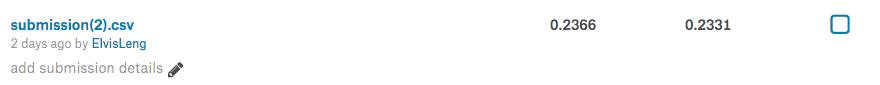